In [1]:
import pandas as pd
import json
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support, ConfusionMatrixDisplay, accuracy_score
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import CamembertTokenizer, CamembertForSequenceClassification, Trainer, TrainingArguments, DataCollatorWithPadding
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

In [2]:
torch.cuda.get_device_name(0)

'NVIDIA GeForce GTX 1080'

In [3]:
# Load the data
train_df = pd.read_csv("../data/train.csv")
train_df = train_df.set_index("id")
train_df.entities = train_df.entities.apply(json.loads)  # Parse entities
train_df.relations = train_df.relations.apply(json.loads)  # Parse relations

# Display the first few rows
train_df.head()

,text,entities,relations
id,,,
181,"Anam Destresse, président de l'ONG ""Ma passion...","[{'id': 0, 'mentions': [{'value': 'accident', ...","[[0, STARTED_IN, 9], [7, IS_LOCATED_IN, 9], [5..."
31669,"À Paris, le 8 avril 2022, l'usine de déodorant...","[{'id': 0, 'mentions': [{'value': 'explosé', '...","[[9, IS_LOCATED_IN, 8], [11, OPERATES_IN, 8], ..."
51470,"En Espagne, dans une région agricole, une cont...","[{'id': 0, 'mentions': [{'value': 'contaminati...","[[7, IS_PART_OF, 8], [9, OPERATES_IN, 1], [0, ..."
51332,Un important incendie a fait des ravages dans ...,"[{'id': 0, 'mentions': [{'value': 'incendie', ...","[[12, IS_IN_CONTACT_WITH, 5], [0, IS_LOCATED_I..."
1131,« Je coule » : onze heures après avoir envoyé ...,"[{'id': 0, 'mentions': [{'value': 'renversé', ...","[[9, IS_LOCATED_IN, 2], [0, START_DATE, 17], [..."


In [4]:
# Extract all unique relation types
relation_types = set()
for relations in train_df.relations:
    for rel in relations:
        relation_types.add(rel[1])  # rel[1] is the relation type
relation_types = list(relation_types)
print(len(relation_types), "Relation types:", relation_types)

37 Relation types: ['IS_IN_CONTACT_WITH', 'HAS_LONGITUDE', 'START_DATE', 'DIED_IN', 'HAS_COLOR', 'IS_PART_OF', 'INJURED_NUMBER', 'HAS_LATITUDE', 'STARTED_IN', 'IS_COOPERATING_WITH', 'INITIATED', 'RESIDES_IN', 'WAS_DISSOLVED_IN', 'HAS_FOR_LENGTH', 'CREATED', 'WEIGHS', 'IS_BORN_IN', 'IS_DEAD_ON', 'OPERATES_IN', 'IS_LOCATED_IN', 'DEATHS_NUMBER', 'IS_AT_ODDS_WITH', 'HAS_FOR_HEIGHT', 'HAS_FAMILY_RELATIONSHIP', 'IS_BORN_ON', 'IS_OF_NATIONALITY', 'END_DATE', 'IS_REGISTERED_AS', 'GENDER_FEMALE', 'IS_OF_SIZE', 'WAS_CREATED_IN', 'HAS_QUANTITY', 'HAS_CONTROL_OVER', 'GENDER_MALE', 'HAS_CATEGORY', 'HAS_FOR_WIDTH', 'HAS_CONSEQUENCE']


In [5]:
ONTOLOGY_RELATIONS = [
    "HAS_CONTROL_OVER",
    "STARTED_IN",
    "IS_LOCATED_IN",
    "HAS_CATEGORY",
    "IS_PART_OF",
    "INJURED_NUMBER",
    "IS_OF_NATIONALITY",
    "OPERATES_IN",
    "INITIATED",
    "RESIDES_IN",
    "HAS_CONSEQUENCE",
    "IS_COOPERATING_WITH",
    "IS_IN_CONTACT_WITH",
    "IS_OF_SIZE",
    "HAS_QUANTITY",
    "HAS_FOR_LENGTH",
    "IS_BORN_IN",
    "WEIGHS",
    "HAS_FOR_WIDTH",
    "HAS_COLOR",
    "HAS_LATITUDE",
    "IS_REGISTERED_AS",
    "IS_AT_ODDS_WITH",
    "CREATED",
    "HAS_FAMILY_RELATIONSHIP",
    "DEATHS_NUMBER",
    "HAS_FOR_HEIGHT",
    "HAS_LONGITUDE",
    "IS_DEAD_ON",
    "START_DATE",
    "END_DATE",
    "WAS_CREATED_IN",
    "IS_BORN_ON",
    "WAS_DISSOLVED_IN",
    "DIED_IN",
    "GENDER_FEMALE",
    "GENDER_MALE",
]

In [6]:
print(len(ONTOLOGY_RELATIONS))

37


# 1 - Preprocess

In [7]:
# Function to mark entities in the text
def mark_entities(text, entities):
    marked_text = text
    for entity in entities:
        mention = entity["mentions"][0]
        value, start, end = mention["value"], mention["start"], mention["end"]
        marked_text = f"{marked_text[:start]}[E{entity['id']}]{value}[/E{entity['id']}]{marked_text[end:]}"
    return marked_text

# Prepare the dataset
def prepare_dataset(df, relation_types):
    data = []
    for _, row in df.iterrows():
        text = row["text"]
        entities = row["entities"]
        relations = row["relations"]
        marked_text = mark_entities(text, entities)
        for rel in relations:
            e1_id, rel_type, e2_id = rel
            data.append({"text": marked_text, "label": relation_types.index(rel_type)})
    return data

# Split the dataset
dataset = prepare_dataset(train_df, relation_types)
train_data, val_data = train_test_split(dataset, test_size=0.2, random_state=42)

In [8]:
# Load CamemBERT tokenizer
tokenizer = CamembertTokenizer.from_pretrained("camembert-base")

# Custom Dataset Class
class RelationDataset(Dataset):
    def __init__(self, data, tokenizer, max_length=512):
        self.data = data
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        encoding = self.tokenizer(
            item["text"],
            truncation=True,
            max_length=self.max_length,
            return_attention_mask=True,
        )
        return {
            "input_ids": encoding["input_ids"],
            "attention_mask": encoding["attention_mask"],
            "labels": item["label"],
        }

train_dataset = RelationDataset(train_data, tokenizer)
val_dataset = RelationDataset(val_data, tokenizer)

In [9]:
# Data collator for dynamic padding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# 2 - Train

In [10]:
# Load CamemBERT with a classification head
model = CamembertForSequenceClassification.from_pretrained(
    "camembert-base",
    num_labels=len(relation_types)
)

Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at camembert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:
# Compute metrics function
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    print(f"Label distribution: {Counter(labels)}")
    
    # Overall metrics
    accuracy = accuracy_score(labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='weighted', zero_division=0)
    
    # Per-class metrics
    class_report = classification_report(labels, predictions, target_names=relation_types, output_dict=True, zero_division=0)
    
    # Prepare the results dictionary
    results = {
        'accuracy': accuracy,
        'f1_weighted': f1,
        'precision_weighted': precision,
        'recall_weighted': recall,
    }
    
    # Add per-class metrics
    for cls in relation_types:
        results[f'f1_{cls}'] = class_report[cls]['f1-score']
        results[f'precision_{cls}'] = class_report[cls]['precision']
        results[f'recall_{cls}'] = class_report[cls]['recall']
    
    return results
    
    # return {
    #     'accuracy': accuracy,
    #     'f1_weighted': f1,
    #     'precision_weighted': precision,
    #     'recall_weighted': recall,
    #     **{f'f1_{cls}': class_report[cls]['f1-score'] for cls in relation_types},  # Per-class F1
    #     **{f'precision_{cls}': class_report[cls]['precision'] for cls in relation_types},  # Per-class precision
    #     **{f'recall_{cls}': class_report[cls]['recall'] for cls in relation_types},  # Per-class recall
    # }

In [12]:
# Define training arguments
training_args = TrainingArguments(
    output_dir="../results",
    num_train_epochs=2,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    learning_rate=2e-5,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir="./logs",
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=2,
    load_best_model_at_end=True,
)

# Trainer with data collator
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset, # Automatically shuffled
    eval_dataset=val_dataset,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

In [13]:
# Train the model
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1 Weighted,Precision Weighted,Recall Weighted,F1 Is In Contact With,F1 Has Longitude,F1 Start Date,F1 Died In,F1 Has Color,F1 Is Part Of,F1 Injured Number,F1 Has Latitude,F1 Started In,F1 Is Cooperating With,F1 Initiated,F1 Resides In,F1 Was Dissolved In,F1 Has For Length,F1 Created,F1 Weighs,F1 Is Born In,F1 Is Dead On,F1 Operates In,F1 Is Located In,F1 Deaths Number,F1 Is At Odds With,F1 Has For Height,F1 Has Family Relationship,F1 Is Born On,F1 Is Of Nationality,F1 End Date,F1 Is Registered As,F1 Gender Female,F1 Is Of Size,F1 Was Created In,F1 Has Quantity,F1 Has Control Over,F1 Gender Male,F1 Has Category,F1 Has For Width,F1 Has Consequence,Precision Is In Contact With,Precision Has Longitude,Precision Start Date,Precision Died In,Precision Has Color,Precision Is Part Of,Precision Injured Number,Precision Has Latitude,Precision Started In,Precision Is Cooperating With,Precision Initiated,Precision Resides In,Precision Was Dissolved In,Precision Has For Length,Precision Created,Precision Weighs,Precision Is Born In,Precision Is Dead On,Precision Operates In,Precision Is Located In,Precision Deaths Number,Precision Is At Odds With,Precision Has For Height,Precision Has Family Relationship,Precision Is Born On,Precision Is Of Nationality,Precision End Date,Precision Is Registered As,Precision Gender Female,Precision Is Of Size,Precision Was Created In,Precision Has Quantity,Precision Has Control Over,Precision Gender Male,Precision Has Category,Precision Has For Width,Precision Has Consequence,Recall Is In Contact With,Recall Has Longitude,Recall Start Date,Recall Died In,Recall Has Color,Recall Is Part Of,Recall Injured Number,Recall Has Latitude,Recall Started In,Recall Is Cooperating With,Recall Initiated,Recall Resides In,Recall Was Dissolved In,Recall Has For Length,Recall Created,Recall Weighs,Recall Is Born In,Recall Is Dead On,Recall Operates In,Recall Is Located In,Recall Deaths Number,Recall Is At Odds With,Recall Has For Height,Recall Has Family Relationship,Recall Is Born On,Recall Is Of Nationality,Recall End Date,Recall Is Registered As,Recall Gender Female,Recall Is Of Size,Recall Was Created In,Recall Has Quantity,Recall Has Control Over,Recall Gender Male,Recall Has Category,Recall Has For Width,Recall Has Consequence
1,2.534000,2.520396,0.287099,0.128080,0.082426,0.287099,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.446118,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.287099,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,2.531200,2.510795,0.287099,0.128080,0.082426,0.287099,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.446118,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.287099,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000

c:\Users\thebo\Desktop\TextMine25\env_textmine\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\thebo\Desktop\TextMine25\env_textmine\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


TrainOutput(global_step=3148, training_loss=2.589245671389821, metrics={'train_runtime': 22436.1376, 'train_samples_per_second': 2.244, 'train_steps_per_second': 0.14, 'total_flos': 1.20155600855583e+16, 'train_loss': 2.589245671389821, 'epoch': 2.0})

# 3 - Evaluate

<Figure size 2000x800 with 0 Axes>

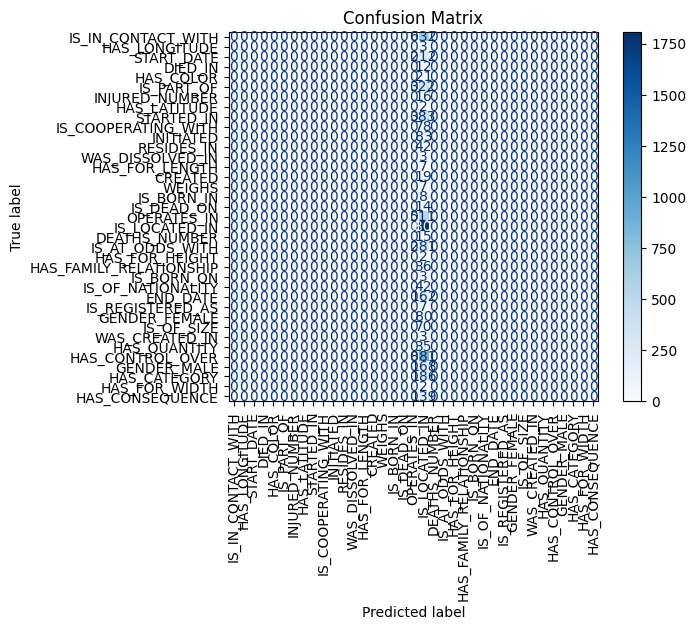

Per-Class Performance Report:
                      Class  Precision  Recall  F1-Score  Support
0        IS_IN_CONTACT_WITH   0.000000     0.0  0.000000      632
1             HAS_LONGITUDE   0.000000     0.0  0.000000        3
2                START_DATE   0.000000     0.0  0.000000      212
3                   DIED_IN   0.000000     0.0  0.000000       12
4                 HAS_COLOR   0.000000     0.0  0.000000       21
5                IS_PART_OF   0.000000     0.0  0.000000      322
6            INJURED_NUMBER   0.000000     0.0  0.000000       16
7              HAS_LATITUDE   0.000000     0.0  0.000000        2
8                STARTED_IN   0.000000     0.0  0.000000      383
9       IS_COOPERATING_WITH   0.000000     0.0  0.000000       78
10                INITIATED   0.000000     0.0  0.000000       83
11               RESIDES_IN   0.000000     0.0  0.000000       42
12         WAS_DISSOLVED_IN   0.000000     0.0  0.000000        3
13           HAS_FOR_LENGTH   0.000000     0.0

In [14]:
def evaluate_per_class(model, dataloader, relation_types, device='cuda'):
    model = model.to(device)
    model.eval()
    predictions, labels = [], []

    # Process the dataset in batches
    for batch in dataloader:
        inputs = {
            'input_ids': batch['input_ids'].to(device),
            'attention_mask': batch['attention_mask'].to(device),
            'labels': batch['labels'].to(device)
        }
        
        with torch.no_grad():
            outputs = model(**inputs)
        logits = outputs.logits
        predictions.extend(torch.argmax(logits, dim=-1).cpu().numpy())
        labels.extend(inputs['labels'].cpu().numpy())

    # Compute per-class metrics
    precision, recall, f1, support = precision_recall_fscore_support(
        labels, predictions, labels=list(range(len(relation_types))), average=None, zero_division=0
    )

    # Create a DataFrame for better readability
    report_df = pd.DataFrame({
        'Class': relation_types,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'Support': support
    })

    # Generate confusion matrix
    plt.figure(figsize=(20, 8))
    cm = confusion_matrix(labels, predictions, labels=list(range(len(relation_types))))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=relation_types)
    disp.plot(cmap=plt.cm.Blues, xticks_rotation=90)
    plt.title("Confusion Matrix")
    plt.show()

    return report_df

val_loader = DataLoader(
    val_dataset,
    batch_size=16,
    shuffle=False,
    collate_fn=data_collator,
)

# Evaluate per-class performance on the validation set
report_df = evaluate_per_class(model, val_loader, relation_types)

# Print the report
print("Per-Class Performance Report:")
print(report_df)

In [ ]:
#is located in is the only one working???

In [15]:
# Save the model
model.save_pretrained("../camembert-relation-extraction")
tokenizer.save_pretrained("../camembert-relation-extraction")

('../camembert-relation-extraction\\tokenizer_config.json',
 '../camembert-relation-extraction\\special_tokens_map.json',
 '../camembert-relation-extraction\\sentencepiece.bpe.model',
 '../camembert-relation-extraction\\added_tokens.json')

# 4 - Predict

In [16]:
# Load the model
model = CamembertForSequenceClassification.from_pretrained("../camembert-relation-extraction")
tokenizer = CamembertTokenizer.from_pretrained("../camembert-relation-extraction")

# Example prediction
test_text = "[E1]Anam Destresse[/E1] a été blessé dans un accident impliquant un [E2]bus[/E2]."
inputs = tokenizer(test_text, return_tensors="pt", padding=True, truncation=True)
outputs = model(**inputs)
predicted_label = outputs.logits.argmax(dim=-1).item()
predicted_relation = relation_types[predicted_label]

print(f"Predicted relation: {predicted_relation}")

Predicted relation: IS_LOCATED_IN


Class Weights:
Use class weights in the loss function to penalize misclassifications in minority classes more heavily.

Oversampling/Downsampling:
Oversample minority classes or downsample majority classes during training.

Data Augmentation:
Augment data for minority classes to balance the dataset.